In [1]:
import sys

# New Section

In [2]:
# To add your own Drive Run this cell.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Please append your own directory after ‘/content/drive/My Drive/'
# where you have nutil.py and adult_subsample.csv
### ========== TODO : START ========== ###
sys.path += ['/content/drive/My Drive/CS/CSM146'] 
### ========== TODO : END ========== ###


In [5]:
from nutil import *

In [ ]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

In [ ]:
######################################################################
# Immutatble classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [ ]:
######################################################################
# Mutatble classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ###
        # part b: set self.probabilities_ according to the training set
        self.probabilities_= {1: (sum(y)/len(y)), 0: 1-(sum(y)/len(y))}

        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== TODO : START ========== ###
        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)
        y = np.random.choice(2, X.shape[0],p=[self.probabilities_[0], self.probabilities_[1]])    
        
        ### ========== TODO : END ========== ###

        return y


In [ ]:
######################################################################
# Immutatble functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels


In [ ]:
######################################################################
# Mutatble functions
######################################################################

def error(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    ### ========== TODO : START ========== ###
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    total_train_error = 0
    total_test_error = 0
    total_f1_score = 0
    sss = StratifiedShuffleSplit(n_splits=ntrials, test_size=test_size, random_state=0)
    for (train_index, test_index) in sss.split(X, y):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      clf.fit(X_train, y_train)                  # fit training data using the classifier
      y_pred_train = clf.predict(X_train)        # take the classifier and run it on the training data
      total_train_error += 1 - metrics.accuracy_score(y_train, y_pred_train, normalize=True)

      y_pred_test = clf.predict(X_test)        # take the classifier and run it on the test data
      total_test_error += 1 - metrics.accuracy_score(y_test, y_pred_test, normalize=True)

      total_f1_score += metrics.f1_score(y_test, y_pred_test, average='micro')

    ### ========== TODO : END ========== ###
    
    train_error = total_train_error/ntrials
    test_error = total_test_error/ntrials
    f1_score = total_f1_score/ntrials

    return train_error, test_error, f1_score




In [ ]:
######################################################################
# Immutatble functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()


Plotting...


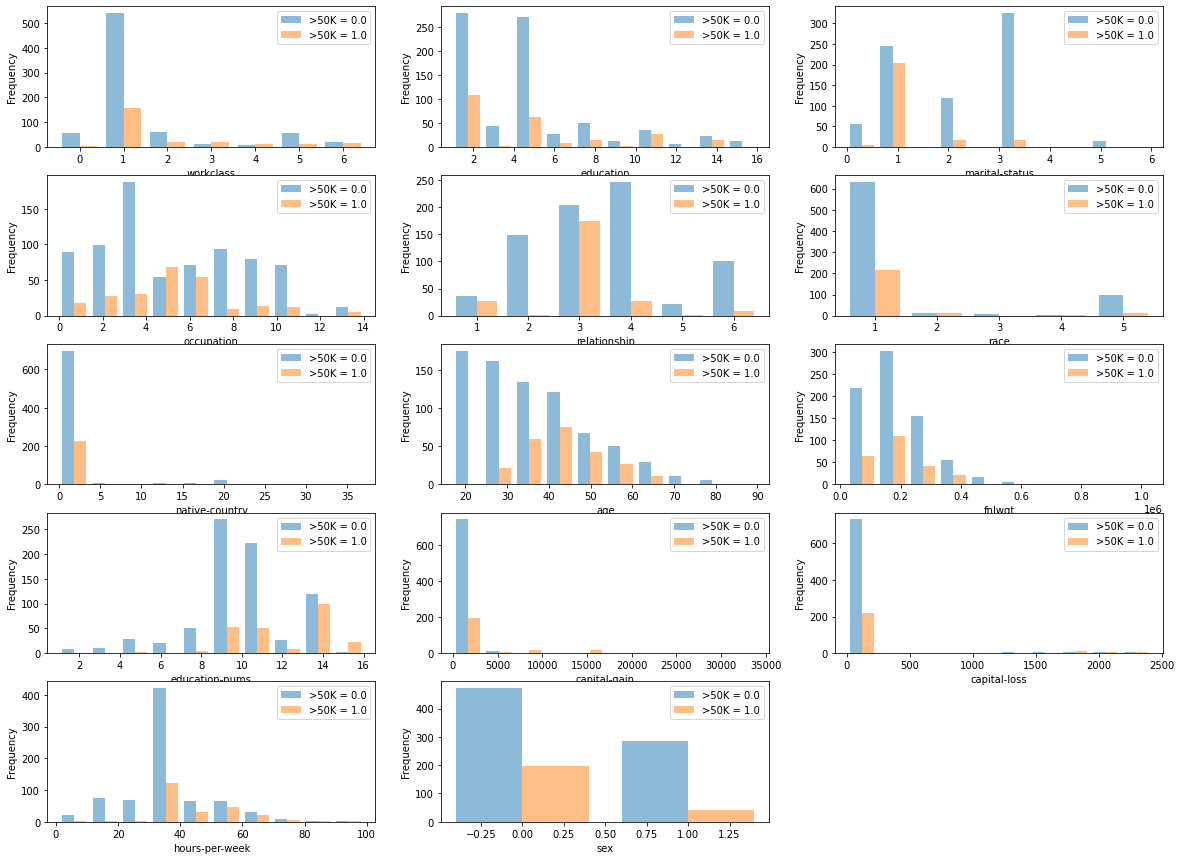

Classifying using Majority Vote...
	-- training error: 0.240
Classifying using Random...
	-- training error: 0.374
Classifying using Decision Tree...
	-- training error: 0.000
Classifying using k-Nearest Neighbors...
	-- training error for 3 neighbors: 0.153
	-- training error for 5 neighbors: 0.195
	-- training error for 7 neighbors: 0.213
Investigating various classifiers...
For <__main__.MajorityVoteClassifier object at 0x7f73c39887c0>:
	-- training error: 0.240
	-- testing error: 0.240
	-- F1 score: 0.760
For <__main__.RandomClassifier object at 0x7f73c3b50df0>:
	-- training error: 0.375
	-- testing error: 0.382
	-- F1 score: 0.618
For DecisionTreeClassifier(criterion='entropy'):
	-- training error: 0.000
	-- testing error: 0.205
	-- F1 score: 0.795
For KNeighborsClassifier():
	-- training error: 0.202
	-- testing error: 0.259
	-- F1 score: 0.741
Finding the best k...
	-- training error for 1 neighbors: 0.302
	-- training error for 3 neighbors: 0.277
	-- training error for 5 neighb

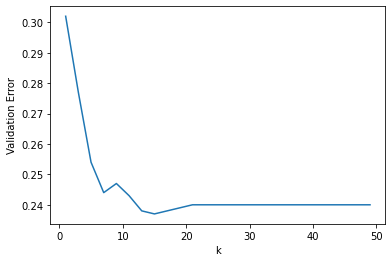

Investigating depths...
	-- training error for 1 depth: 0.240
	-- testing  error for 1 depth: 0.240
	-- training error for 2 depth: 0.195
	-- testing  error for 2 depth: 0.218
	-- training error for 3 depth: 0.170
	-- testing  error for 3 depth: 0.185
	-- training error for 4 depth: 0.161
	-- testing  error for 4 depth: 0.180
	-- training error for 5 depth: 0.149
	-- testing  error for 5 depth: 0.172
	-- training error for 6 depth: 0.135
	-- testing  error for 6 depth: 0.175
	-- training error for 7 depth: 0.118
	-- testing  error for 7 depth: 0.199
	-- training error for 8 depth: 0.099
	-- testing  error for 8 depth: 0.204
	-- training error for 9 depth: 0.088
	-- testing  error for 9 depth: 0.205
	-- training error for 10 depth: 0.074
	-- testing  error for 10 depth: 0.199
	-- training error for 11 depth: 0.063
	-- testing  error for 11 depth: 0.201
	-- training error for 12 depth: 0.050
	-- testing  error for 12 depth: 0.213
	-- training error for 13 depth: 0.040
	-- testing  error 

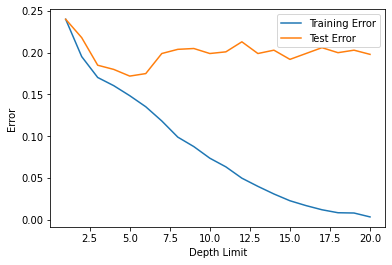

Investigating training set size...


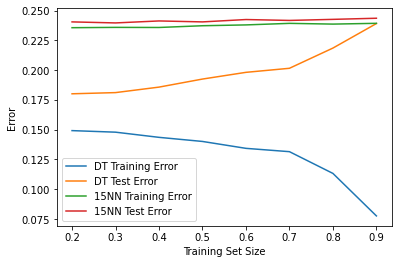

Investigating training set sizes...


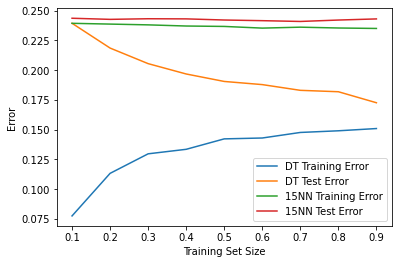

Done


In [ ]:

######################################################################
# main
######################################################################

def main():
    
    
    
    # load adult_subsample dataset with correct file path
    ### ========== TODO : START ========== ###
    data_file =  "/content/drive/My Drive/CS/CSM146/adult_subsample.csv"
    
    ### ========== TODO : END ========== ###
    

    data = load_data(data_file, header=1, predict_col=-1)


    X = data.X; Xnames = data.Xnames
    y = data.y; yname = data.yname
    n,d = X.shape  # n = number of examples, d =  number of features


    #========================================
    # part a: plot histograms of each feature
    print('Plotting...')
    plot_histograms (X, y, Xnames=Xnames, yname=yname)
    plt.show()
  


    ### ========== TODO : START ========== ###
    # part i: Preprocess X (e.g., normalize)
    # (try this after finishing the sections below)
    
    # scaler = StandardScaler()
    # X = scaler.fit_transform(X)

    ### ========== TODO : END ========== ###




    #========================================
    # train Majority Vote classifier on data
    print('Classifying using Majority Vote...')
    MV_clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
    MV_clf.fit(X, y)                  # fit training data using the classifier
    y_pred = MV_clf.predict(X)        # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)





    ### ========== TODO : START ========== ###
    # part b: evaluate training error of Random classifier
    print('Classifying using Random...')
    rand_clf = RandomClassifier() # create MajorityVote classifier, which includes all model parameters
    rand_clf.fit(X, y)                  # fit training data using the classifier
    y_pred = rand_clf.predict(X)        # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part c: evaluate training error of Decision Tree classifier
    print('Classifying using Decision Tree...')
    DT_clf = DecisionTreeClassifier(criterion='entropy')
    DT_clf.fit(X,y)
    y_pred = DT_clf.predict(X)        # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part d: evaluate training error of k-Nearest Neighbors classifier
    # use k = 3, 5, 7 for n_neighbors
    print('Classifying using k-Nearest Neighbors...')
    for k in [3, 5, 7]:
      clf = KNeighborsClassifier(n_neighbors=k)
      clf.fit(X,y)
      y_pred = clf.predict(X)        # take the classifier and run it on the training data
      train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
      # print the error for each k
      print('\t-- training error for '+str(k)+' neighbors: %.3f' % train_error)
    
    K5_clf = KNeighborsClassifier(n_neighbors=5)
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part e: use cross-validation to compute average training and test error of classifiers
    print('Investigating various classifiers...')

    clfs = [MV_clf, rand_clf, DT_clf, K5_clf]
    
    for clf in clfs:
      summary = error(clf, X, y)
      print('For '+str(clf)+':')
      print('\t-- training error: %.3f' % summary[0])
      print('\t-- testing error: %.3f' % summary[1])
      print('\t-- F1 score: %.3f' % summary[2])


    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part f: use 10-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
    print('Finding the best k...')
    min = 1
    best_k = 0
    errors = []
    k_vals = range(1, 50, 2)
    for k in k_vals:
      clf = KNeighborsClassifier(n_neighbors=k)
      cv_scores = cross_val_score(clf, X, y, cv=10)
      err = 1-np.mean(cv_scores)
      print('\t-- training error for %g neighbors: %.3f' % (k, err))
      if err < min:
        min = err
        best_k = k
      errors.append(err)

    print('The best k according to 10-fold cross-validation is', best_k)

    plt.plot(k_vals, errors)
    plt.xlabel('k')
    plt.ylabel('Validation Error')
    plt.show()
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part g: investigate decision tree classifier with various depths
    print('Investigating depths...')
    min = 1
    best_d = 0
    train_errors = []
    test_errors = []
    depths = range(1, 21)
    for d in depths:
      clf = DecisionTreeClassifier(criterion='entropy', max_depth=d)
      cv_scores = cross_validate(clf, X, y, cv=10, return_train_score=True)
      train_error = 1-np.mean(cv_scores['train_score'])
      test_error = 1-np.mean(cv_scores['test_score'])
      train_errors.append(train_error)
      test_errors.append(test_error)
      print('\t-- training error for %g depth: %.3f' % (d, train_error))
      print('\t-- testing  error for %g depth: %.3f' % (d, test_error))
      if test_error < min:
        min = test_error
        best_d = d
    
    print('The best depth according to 10-fold cross-validation is', best_d)

    plt.plot(depths, train_errors, label='Training Error')
    plt.plot(depths, test_errors, label='Test Error')
    plt.xlabel('Depth Limit')
    plt.ylabel('Error')
    plt.legend()
    plt.show()

    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part h: investigate decision tree and k-Nearest Neighbors classifier with various training set sizes
    # hint: use train_test_split (use random_state=0 for consistent results)
    print('Investigating training set size...')

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1,random_state=0)

    DT_train_errors = []
    DT_test_errors = []
    K15_train_errors = []
    K15_test_errors = []

    train_sizes = np.arange(0.9, 0.1, -0.10)

    for size in train_sizes:
        # decision tree classifier
        DT_clf = DecisionTreeClassifier(criterion='entropy', max_depth=5)
        train_error, test_error, F1 = error(DT_clf, X, y, ntrials=100, test_size=size)
        DT_train_errors.append(train_error)
        DT_test_errors.append(test_error)

        # DT_clf.fit(X_train[:int(X_train.shape[0] * size)], y_train[:int(y_train.shape[0] * size)])
        # DT_train_errors.append(1 - DT_clf.score(X_train[:int(X_train.shape[0] * size)], y_train[:int(y_train.shape[0] * size)]))
        # DT_test_errors.append(1 - DT_clf.score(X_test, y_test))
        
        # 15-nearest neighbors classifier
        K15_clf = KNeighborsClassifier(n_neighbors=15)
        train_error, test_error, F1 = error(K15_clf, X, y, ntrials=100, test_size=size)
        K15_train_errors.append(train_error)
        K15_test_errors.append(test_error)
        

        # K15_clf.fit(X_train[:int(X_train.shape[0] * size)], y_train[:int(y_train.shape[0] * size)])
        # K15_train_errors.append(1 - K15_clf.score(X_train[:int(X_train.shape[0] * size)], y_train[:int(y_train.shape[0] * size)]))
        # K15_test_errors.append(1 - K15_clf.score(X_test, y_test))

    # plot the relationship between training set size and mean training and test error for both classifiers
    plt.plot(train_sizes, DT_train_errors, label='DT Training Error')
    plt.plot(train_sizes, DT_test_errors, label='DT Test Error')
    plt.plot(train_sizes, K15_train_errors, label='15NN Training Error')
    plt.plot(train_sizes, K15_test_errors, label='15NN Test Error')
    plt.xlabel('Training Set Size')
    plt.ylabel('Error')
    plt.legend()
    plt.show()
    ### ========== TODO : END ========== ###



    print('Investigating training set sizes...')
    #  generate a random 90/10 split of the training data and do the following experiments considering the 90% fraction as training and 10% for testing
    clf = DecisionTreeClassifier(criterion="entropy",
                                  max_depth=3)  # create MajorityVote classifier, which includes all model parameters
    train_error, test_error, F1 = error(clf, X, y, ntrials=100, test_size=0.1)
    clf = KNeighborsClassifier(n_neighbors=15)  # create MajorityVote classifier, which includes all model parameters
    train_error, test_error, F1 = error(clf, X, y, ntrials=100, test_size=0.1)

    # d_range = range(0.1, 1, 0.1)
    # # empty list to store scores
    DT_train_score = []
    DT_test_score = []
    tr_d = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    test_d = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    # 1. we will loop through reasonable values of k
    for t_t in test_d:
        clf = DecisionTreeClassifier(criterion="entropy", max_depth=5)
        train_error, test_error, F1 = error(clf, X, y, ntrials=100, test_size=t_t)
        DT_train_score.append(train_error)
        DT_test_score.append(test_error)

    # plt.plot(tr_d, train_score, tr_d, test_score)
    # plt.xlabel('Training Data Amount')
    # plt.ylabel('Decision Tree Train/Test Error')
    # plt.show()

    K_train_score = []
    K_test_score = []
    tr_d = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    test_d = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

    # 1. we will loop through reasonable values of k
    for t_t in test_d:
        clf = KNeighborsClassifier(n_neighbors=15)
        train_error, test_error, F1 = error(clf, X, y, ntrials=100, test_size=t_t)
        K_train_score.append(train_error)
        K_test_score.append(test_error)

    # plt.plot(tr_d, train_score, tr_d, test_score)
    # plt.xlabel('Training Data Amount')
    # plt.ylabel('KNN Train /Test Error')
    # plt.show()
    plt.plot(tr_d, DT_train_score, label='DT Training Error')
    plt.plot(tr_d, DT_test_score, label='DT Test Error')
    plt.plot(tr_d, K_train_score, label='15NN Training Error')
    plt.plot(tr_d, K_test_score, label='15NN Test Error')
    plt.xlabel('Training Set Size')
    plt.ylabel('Error')
    plt.legend()
    plt.show()
    ### ========== TODO : END ========== ###


    print('Done')


if __name__ == "__main__":
    main()
